# Extraction of diffraction peaks from diffuse background

This example works by weighing the area under a
peak with positive values and surrounding the peak with a ring of
negative weight pixels in such a way that the total sum is 0. Applying
this mask to a constant background consequently yields 0, and only
differences between spot and surrounding ring show up in the result as
positive or negative values.

Sample data courtesy of Ian MacLaren <Ian.MacLaren@glasgow.ac.uk> and
Shane McCartan <s.mccartan.1@research.gla.ac.uk>, University of Glasgow

Sample preparation: David Hall and Ilkan Calisir

The dataset is from a solid solution ceramic of bismuth ferrite and barium 
titanate (ratio: 75%/25%) doped 3% Ti. Chemical segregation of the bismuth 
ferrite and barium titanate occurs in the formation of the core-shell type 
structure that you can see in the grain (barium titanate-shell, bismuth 
ferrite-core). The grain is orientated along the [110] direction as the 
extra spots that BFO produces at the 1/2 (111) positions are obvious in 
this orientation. Otherwise the diffraction patterns of BFO and BTO are 
too similar to distinguish easily.

## Import libraries

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from libertem_blobfinder.common import correlation as corr
from libertem_blobfinder.common import patterns

import libertem.api as lt
import libertem.masks as ltmasks
import libertem.analysis.fullmatch as fm
import libertem.analysis.gridmatching as grm

In [3]:
%precision 4

'%.4f'

## Create LiberTEM Context
Start a local cluster (default). Connecting to a running cluster is possible as well.

In [4]:
ctx = lt.Context()

## Load file
The parameters depend on the data set type. We can get basic information about the file from the dataset, for example its dimensions.

In [5]:
data_base_path = os.environ.get("TESTDATA_BASE_PATH", "/home/alex/Data/")

In [6]:
path = os.path.join(data_base_path, "default.blo")
ds = ctx.load(
    "blo",
    path=path,
)

# we could also use the new type="auto" feature:
# ds = ctx.load('auto', path=path)

(scan_y, scan_x, detector_y, detector_x) = ds.shape
mask_shape = np.array((detector_y, detector_x))

## Extract a sample frame

Load and show a single frame at given coordinates in the data set. The coordinates were determined with the LiberTEM GUI in "pick" mode.

This function should not be used to load and process larger parts of a dataset since it sends the data through the cluster and performs calculations on the control node, not on the workers. If you have special processing in mind, LiberTEM offers a powerful interface to define user-defined functions (UDFs): https://libertem.github.io/LiberTEM/udf.html

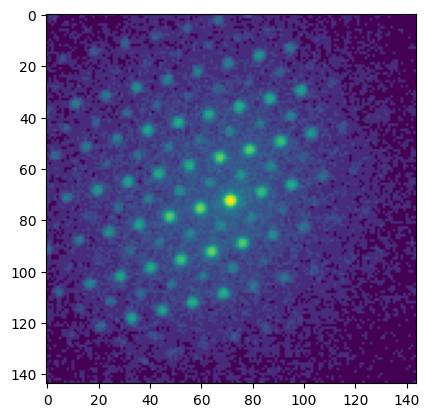

In [7]:
get_sample_frame = ctx.create_pick_analysis(dataset=ds, y=60, x=75)
sample_frame_result = ctx.run(get_sample_frame)
sample_frame = sample_frame_result.intensity.raw_data.astype(np.float32)

log_frame = np.log(sample_frame - sample_frame.min() + 1)

fig, axes = plt.subplots()
axes.imshow(log_frame)

## Construct masks that extract peak families
The `BackgroundSubtraction` pattern consists of a central disk with positive values that is surrounded by a ring with negative values. Applying it to a constant background or linear gradient yields exactly zero, and applying it to random noise tends towards zero as well.

Sum:  -1.1102230246251565e-16


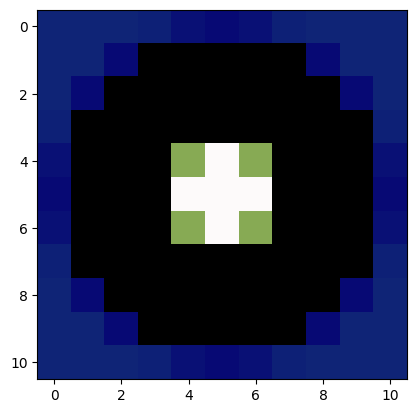

In [8]:
match_pattern = patterns.BackgroundSubtraction(radius=1.5, radius_outer=5)

sample_mask = match_pattern.get_mask((11,11))

# This is close to zero.
print("Sum: ", sample_mask.sum())

fig, axes = plt.subplots()
axes.imshow(sample_mask, cmap=cm.gist_earth)

## Construct a parallelogram grid

For better signal-to-noise ratio and less sensitivity to the exact diffraction conditions we want to sum up data from many corresponding peaks. We could just list all the coordinates by hand, but that's a bit tedious. Instead, we use the blobfinder to first extract peak positions. The peak radius can be determined from a sample frame in the LiberTEM GUI or in scripting by visually fitting a circle over it. A good match of peak shape and template improves the fit quality tremendously.

Then, we use the `libertem.analysis.fullmatch.FullMatcher.full_match()` method to extract grid parameters. The most intense peak is used as origin by default.

For a more fancy version, one could use computational crystallography to calculate the positions. 

In [9]:
r = 1.5

match_pattern = patterns.BackgroundSubtraction(radius=r, radius_outer=5)
matcher = fm.FullMatcher()

peaks = corr.get_peaks(sum_result=log_frame, match_pattern=match_pattern, num_peaks=40)
(matches, unmatched, weak) = matcher.full_match(peaks)

We check the grid that it found by visualizing the peaks and grid vectors. Potentially it could fit the main lattice or the superlattice. In this case it only found main lattice peaks because they are more intense. Increasing `num_disks` to 80 would find both main lattice and superlattice peaks, and consequently return the superlattice grid vectors that match both peak families together.

Text(0.5, 1.0, 'Found peak positions and grid match')

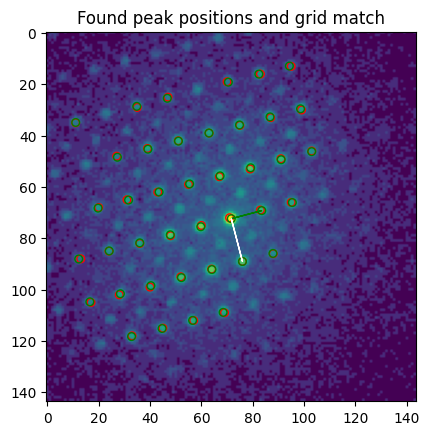

In [10]:
fig, axes = plt.subplots()
axes.imshow(log_frame)

# We use the first and only match
m = matches[0]

# Plot red circles for the subpixel positions of each peak
for p in np.flip(m.refineds, axis=1):
    axes.add_artist(plt.Circle(p, r, color="r", fill=False))
# Plot green circles for the best fit positions
for p in np.flip(m.calculated_refineds, axis=1):
    axes.add_artist(plt.Circle(p, r, color="g", fill=False))
# Plot the grid's unit vectors
plt.arrow(*np.flip(m.zero), *(np.flip(m.a)), color='g')
plt.arrow(*np.flip(m.zero), *(np.flip(m.b)), color='w')
plt.title("Found peak positions and grid match")

## Adjust indices and grid vectors

We only found a subset of the peaks that can be present in the frame using the matching. Therefore we calculate all indices that are within the frame. We exclude the zero position of the main lattice to eliminate the zero order peak from the virtual darkfield image we want to calculate.

Since we want to fit main lattice and superlattice separately, we can get the correct superlattice parameters just by shifting the zero position by half a diagonal.

In [11]:
main_lattice = matches[0]

# This is large enough to go well outside the frame
indices = np.mgrid[-10:10, -10:10]

# We shift by half a diagonal
super_lattice = main_lattice.derive(
    zero=main_lattice.zero + (main_lattice.a + main_lattice.b)/2
)

main_peaks = main_lattice.calc_coords(
    indices=indices,
    drop_zero=True,
    frame_shape=mask_shape,
    r=r
)

super_peaks = super_lattice.calc_coords(
    indices=indices,
    frame_shape=mask_shape,
    r=r
)

## Masks with actual peak positions

The LiberTEM Mask Analysis accepts argument-less functions as parameters that have the mask as an output. That way, the mask is not sent through the cluster, only the function that builds it.

We use the `libertem.udf.blobfinder.utils.feature_vector` method to calculate a mask with templates for all positions. This method returns a sparse matrix stack with individual masks for each peak, which we just collapse by summing over the first axis and converting to a dense matrix.

In [12]:
def super_mask():
    stack = patterns.feature_vector(detector_x, detector_y, super_peaks, match_pattern)
    return stack.sum(axis=0).todense()

def base_mask():    
    stack = patterns.feature_vector(detector_x, detector_y, main_peaks, match_pattern)
    return stack.sum(axis=0).todense()

## Show the resulting masks

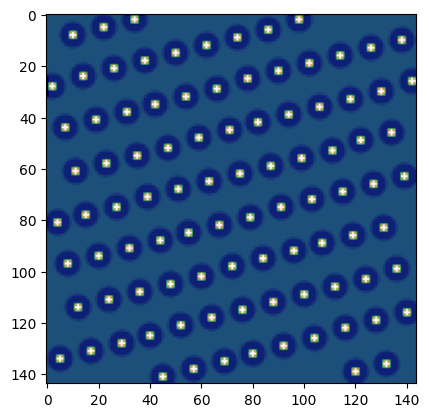

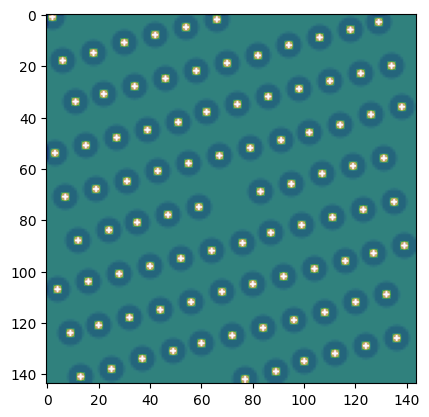

In [13]:
fig, axes = plt.subplots()
axes.imshow(super_mask(), cmap=cm.gist_earth)

fig, axes = plt.subplots()
axes.imshow(base_mask(), cmap=cm.gist_earth)

## Confirm peak positions

Superimpose the sample frame with the calculated peak positions to see if we got positions and sizes right. The mask is subtracted from the sample frame to get a clearer picture.

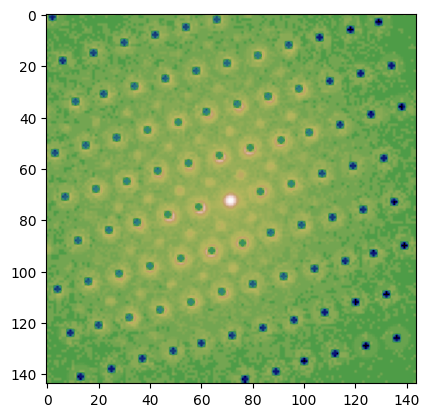

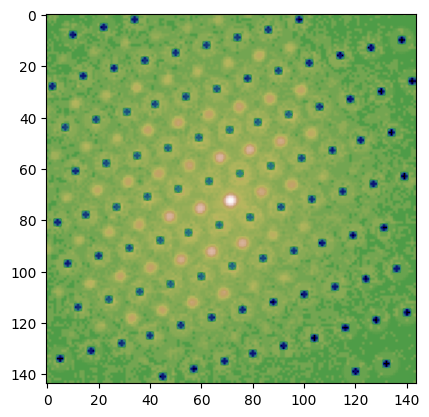

In [14]:
# Check if we got the selectors at the right spot:
# superimposed with base peaks
fig, axes = plt.subplots()
axes.imshow(log_frame - 5*base_mask(), cmap=cm.gist_earth)
# superimposed with superlattice peaks
fig, axes = plt.subplots()
axes.imshow(log_frame - 5*super_mask(), cmap=cm.gist_earth)

## Create an analysis for execution

LiberTEM works by creating Analyses or UDFs that are then sent to the Context for execution. A Mask Analysis multiplies the given masks element-wise with each frame and returns the sum of the result for each mask and frame as a 3D array. The first dimension are the masks, and the second and third are the Y and X direction of scanning, the navigation dimension.

In [15]:
analysis = ctx.create_mask_analysis(factories=[super_mask, base_mask], dataset=ds)

## Execute the analysis

The convention of the LiberTEM API is that in most cases an explicit call of `run()` will perform work on the cluster.

Mask-based processing is highly optimized and will run fast even on a laptop if the file fits into the file system cache. This value was generated on a system with a Core i3-4030U and 8 GB RAM.

In [16]:
%%time
result = ctx.run(analysis, progress=True)

Partitions 0/24, Frames:   0%|          | 0/10890 [00:00<?, ?it/s]

CPU times: user 333 ms, sys: 12 ms, total: 345 ms
Wall time: 1.18 s


## Show the result

In [17]:
print(result)

[<AnalysisResult: mask_0>, <AnalysisResult: mask_1>]


The result contains both raw and visualized data since it is an Analysis that can prepare data for display in the GUI as well.

In [18]:
print(result.mask_0, result.mask_1)

title: mask 0
desc: integrated intensity for mask 0
key: mask_0
raw_data: [[ -4.2764   6.0913 -30.5467 ... -46.3953 -39.5375 -33.3064]
 [  5.1629 -14.2587  32.0065 ... -37.2169 -31.0866 -36.5465]
 [ 10.0689   3.488    5.2979 ... -40.3877 -47.0148 -47.3074]
 ...
 [-43.43   -46.2653 -46.9105 ...  -7.4784 -11.7403   0.6538]
 [ -1.3448  -1.7178  -3.9136 ... -18.7789  -8.8628  -9.9505]
 [  0.       0.       0.     ... -11.871   -9.306   -4.9967]]
visualized: [[[ 27  77 122 255]
  [ 27  77 122 255]
  [ 27  75 121 255]
  ...
  [ 26  73 121 255]
  [ 27  75 121 255]
  [ 27  75 121 255]]

 [[ 27  77 122 255]
  [ 27  75 121 255]
  [ 28  79 122 255]
  ...
  [ 27  75 121 255]
  [ 27  75 121 255]
  [ 27  75 121 255]]

 [[ 27  77 122 255]
  [ 27  77 122 255]
  [ 27  77 122 255]
  ...
  [ 27  75 121 255]
  [ 26  73 121 255]
  [ 26  73 121 255]]

 ...

 [[ 26  73 121 255]
  [ 26  73 121 255]
  [ 26  73 121 255]
  ...
  [ 27  77 122 255]
  [ 27  77 122 255]
  [ 27  77 122 255]]

 [[ 27  77 122 255]
  [ 

Text(0.5, 1.0, 'Base lattice virtual darkfield')

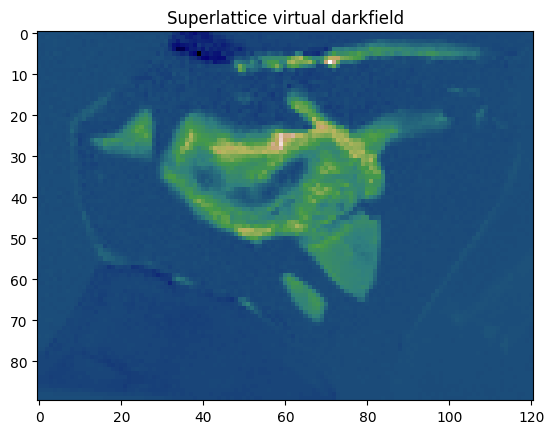

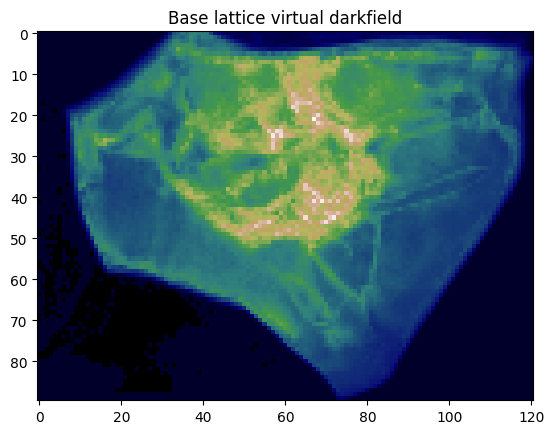

In [19]:
fig, axes = plt.subplots()
axes.imshow(result.mask_0.visualized)
plt.title("Superlattice virtual darkfield")

fig, axes = plt.subplots()
axes.imshow(result.mask_1.visualized)
plt.title("Base lattice virtual darkfield")